# 2 TD learning with function approximation (3 pts.)
Consider the MDP (S, A, p, r, γ), where  
&emsp;&emsp;• S = {1, 2, 3, 4, 5, 6, 7} is the state space;  
&emsp;&emsp;• A = {A, B} is the action space;  
&emsp;&emsp;• The transition probabilities are summarized in the matrices  

![image.info](./pictures/p-matrices.png)

&emsp;&emsp;• r(s, a) = 0 for all pairs (s, a) ∈ S × A.  
&emsp;&emsp;• γ = 0.99

The q-function computed by the two algorithms should be:
&emsp;&emsp;qw(x, a) = sum(k=1, 15)(φk(x, a)wk

In [3]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from fractions import Fraction

import tqdm

In [ ]:
# TD learning with function approximation

class TDLearning(object):
    
    def __init__(self, algorithm='q-learning', steps=500, alpha=0.01, gamma=0.99):
        
        # States are [1, 2, 3, 4, 5, 6, 7]
        self.state_space = np.arange(1, 8)
        
        # Initial state
        self.current_state = 1
        
        # Action space is [A, B]
        self.action_space = ['A', 'B']
        
        # Probability matrix A
        self.p_a = np.zeros((7, 7))
        self.p_a[:, 6] = 1
        
        # Probability matrix B
        self.p_b = np.zeros((7, 7))
        self.p_b[:, :6] = Fraction(1, 6)
        self.p_b[:, 6] = 0
        
        # Reward values are 0 for all action pairs (s, a)
        self.reward = 0
        
        # Initialize number of timesteps, step-size and discount factor
        self.steps = steps
        self.alpha = alpha
        self.gamma = gamma
        
        # Initialize feature vector A - rows: states, columns: features
        self.f_a = np.zeros((7, 15))
        for i in np.arange(7):
            self.f_a[i, i] = 2
        self.f_a[6, 6] = 1
        self.f_a[:, 7] = 2
        self.f_a[6, 7] = 1
        
        # Initialize feature vector B
        self.f_b = np.zeros((7, 15))
        for i in np.arange(7):
            self.f_b[i, i + 8] = 1
        
        # Initialize weights
        self.weights = np.zeros((15, 1)) + 1
        self.weights[6] = 10
        
        # Probability of taking actions
        self.use_a = Fraction(1, 7)
        self.use_b = Fraction(6, 7)
        
        # Algorithm to use
        self.algorithm = algorithm
        
        # History
        self.history = [self.weights]
        self.history_n = [self.get_norm(self.weights)]
        
        
    # Policy to follow - translation of p_a and p_b into conditions
    def use_policy(self, state):
        if np.random.rand() < self.use_a:
            return 7, 0
        else:
            if state < 7:
                return np.random.randint(1, 7), 1
            else:
                return 7, 1
            
    
    def calculate_q(self, state, action):
        if action == 0:
            temp_q = [self.f_a[state-1, i] * self.weights[i][0] for i in np.arange(15)]
            return np.sum(temp_q)
        elif action == 1:
            temp_q = [self.f_b[state-1, i] * self.weights[i][0] for i in np.arange(15)]
            return np.sum(temp_q)
        else:
            return
        
        
    def get_features(self, state, action):
        if action == 0:
            return self.f_a[state-1, :]
        elif action == 1:
            return self.f_b[state-1, :]
        return
    
    
    def get_norm(self, vector):
        return np.sqrt(np.sum(i**2 for i in vector))
    
    
    # Q-Learning iteration loop
    def qlearning_iteration(self):
        
        # Run through N episodes
        for i in np.arange(self.steps):
            
            # Choose action using policy
            next_state, action = self.use_policy(self.current_state)
            
            # Get current Q values
            current_q = self.calculate_q(self.current_state, action)
            
            # Get the Q values at next step
            q_alternative = np.max([self.calculate_q(next_state, i) for i in np.arange(2)])
            
            # Immediate reward R
            new_reward = 0
            
            # TD-target
            temp_target = new_reward + self.gamma*q_alternative - current_q
            #print(self.alpha * temp_target * self.get_features(self.current_state, action))
            
            # Weight update
            weight_update = self.alpha * temp_target * self.get_features(self.current_state, action)
            weight_update = np.reshape(weight_update, (15, 1))
            
            # Assign the weights
            temp_weights = self.weights + weight_update
            self.weights = temp_weights
            
            # Do the action and take next one
            self.current_state = next_state
            
            self.history.append(self.weights)
            self.history_n.append(self.get_norm(self.weights)[0])
            
        #print(self.weights)
        
        
    def sarsa_iteration(self):
        
        # Get new state S
        next_state, action = self.use_policy(self.current_state)
        
        for i in np.arange(self.steps):
                
            # Immediate reward R is 0
            new_reward = 0
                
            # Get current Q values
            current_q = self.calculate_q(self.current_state, action)
            
            # Get the next action A'
            temp_state, temp_action = self.use_policy(next_state)
            
            # Get the Q' values
            q_alternative = self.calculate_q(next_state, temp_action)
            
            # TD-target
            temp_target = new_reward + self.gamma*q_alternative - current_q
            
            # Weight update
            weight_update = self.alpha * temp_target * self.get_features(self.current_state, action)
            weight_update = np.reshape(weight_update, (15, 1))
            
            self.current_state = next_state
            self.action = temp_action
            
            self.history.append(self.weights)
            self.history_n.append(self.get_norm(self.weights)[0])
            
        #print(self.weights)
        
        
    def do_iteration(self):
        if self.algorithm == 'q-learning':
            self.qlearning_iteration()
        elif self.algorithm == 'sarsa':
            self.sarsa_iteration()
            
        return

In [69]:
td_test = TDLearning(algorithm='sarsa')
td_test.qlearning_iteration()

<ipython-input-47-a0b7d689c47d>:93: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sqrt(np.sum(i**2 for i in vector))


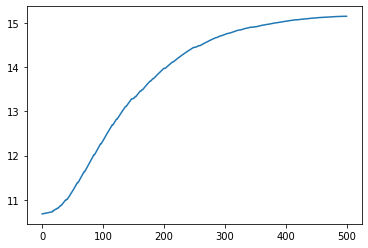

In [70]:
plt.plot(td_test.history_n)

In [61]:
# Do multiple runs of the same algorithm to smooth history values

N_RUNS = 2000

dict_qlearning = {}
dict_sarsa = {}

for i in tqdm.tnrange(N_RUNS):
    temp_q = TDLearning(algorithm='q-learning', steps=500)
    temp_q.do_iteration()
    
    dict_qlearning['Run {:0004d}'.format(i)] = temp_q
    
    temp_s = TDLearning(algorithm='sarsa', steps=500)
    temp_s.do_iteration()
    
    dict_sarsa['Run {:0004d}'.format(i)] = temp_s

<ipython-input-61-2476386f23c1>:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tqdm.tnrange(N_RUNS):


  0%|          | 0/2000 [00:00<?, ?it/s]

<ipython-input-47-a0b7d689c47d>:93: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sqrt(np.sum(i**2 for i in vector))


In [62]:
# Average across all the runs

norm_qlearning_history = []
norm_sarsa_history = []

for key in dict_qlearning.keys():
    norm_qlearning_history.append(dict_qlearning[key].history_n)
    norm_sarsa_history.append(dict_sarsa[key].history_n)